# Trieste

In [2]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [3]:
import os
from omegaconf import OmegaConf
from src.constants import CONFIG_PATH
from sithom.plot import plot_defaults
plot_defaults()

## Now try trieste

In [1]:
import numpy as np
import tensorflow as tf
import trieste
print("Tensorflow version:", tf.__version__)
print("Trieste version:", trieste.__version__)
np.random.seed(1793)
tf.random.set_seed(1793)

2023-06-26 14:54:15.865504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 14:55:22.761325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version: 2.11.1
Trieste version: 1.1.2


In [4]:
from trieste.objectives import ScaledBranin
from trieste.experimental.plotting import plot_function_plotly
from trieste.space import Box

In [5]:
from pandas import Series
from numpy.random import randn

In [24]:
scaled_branin = ScaledBranin.objective
search_space = ScaledBranin.search_space  # predefined search space
search_space = Box([0, 0], [1, 1])  # define the search space directly

In [32]:
from typing import Callable, Optional, Tuple
from trieste.types import TensorType
from trieste.utils import to_numpy
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def create_grid(
    mins: TensorType, maxs: TensorType, grid_density: int = 30
) -> Tuple[TensorType, TensorType, TensorType]:
    """
    Creates a regular 2D grid of size `grid_density^2` between mins and maxs.

    :param mins: list of 2 lower bounds
    :param maxs: list of 2 upper bounds
    :param grid_density: scalar
    :return: Xplot [grid_density**2, 2], xx, yy from meshgrid for the specific formatting of
        contour / surface plots
    """
    tf.debugging.assert_shapes([(mins, [2]), (maxs, [2])])

    xspaced = np.linspace(mins[0], maxs[0], grid_density)
    yspaced = np.linspace(mins[1], maxs[1], grid_density)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(), yy.flatten())).T

    return Xplot, xx, yy


def add_surface_plotly(
    xx: TensorType,
    yy: TensorType,
    f: TensorType,
    fig: go.Figure,
    alpha: float = 1.0,
    figrow: int = 1,
    figcol: int = 1,
) -> go.Figure:
    """
    Adds a surface to an existing plotly subfigure

    :param xx: [n, n] array (input)
    :param yy: [n, n] array (input)
    :param f: [n, n] array (output)
    :param fig: the current plotly figure
    :param alpha: transparency
    :param figrow: row index of the subfigure
    :param figcol: column index of the subfigure
    :return: updated plotly figure
    """

    z = f.reshape([xx.shape[0], yy.shape[1]])

    fig.add_trace(
        go.Surface(z=z, x=xx, y=yy, showscale=False, opacity=alpha, colorscale="viridis"),
        row=figrow,
        col=figcol,
    )
    return fig


def plot_function_plotly(
    obj_func: Callable[[TensorType], TensorType],
    mins: TensorType,
    maxs: TensorType,
    grid_density: int = 20,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    alpha: float = 1.0,
) -> go.Figure:
    """
    Plots 2-dimensional plot of an objective function. To illustrate the function we create a
    regular grid of points and evaluate the function on these points.

    :param obj_func: The vectorized objective function.
    :param mins: List of 2 lower bounds for creating a grid of points for model predictions.
    :param maxs: List of 2 upper bounds for creating a grid of points for model predictions.
    :param grid_density: Number of points per dimension. This will result in a grid size of
        grid_density^2.
    :param title: optional titles
    :param xlabel: optional xlabel
    :param ylabel: optional ylabel
    :param alpha: transparency
    :return: A plotly figure.
    """

    # Create a regular grid on the parameter space
    Xplot, xx, yy = create_grid(mins=mins, maxs=maxs, grid_density=grid_density)

    # Evaluate objective function
    F = to_numpy(obj_func(Xplot))
    if len(F.shape) == 1:
        F = F.reshape(-1, 1)
    n_output = F.shape[1]

    fig = make_subplots(
        rows=1,
        cols=n_output,
        specs=[[{"type": "surface"}] * n_output],
        subplot_titles=title,
    )

    for k in range(n_output):
        f = F[:, k]
        fig = add_surface_plotly(xx, yy, f, fig, alpha=alpha, figrow=1, figcol=k + 1)
        fig.update_xaxes(title_text=xlabel, row=1, col=k + 1)
        fig.update_yaxes(title_text=ylabel, row=1, col=k + 1)

    fig.update_layout(height=600, width=600)

    return fig

In [34]:
import trieste

observer = trieste.objectives.utils.mk_observer(scaled_branin)

num_initial_points = 5
initial_query_points = search_space.sample_sobol(num_initial_points)
initial_data = observer(initial_query_points)

In [35]:
import gpflow
import tensorflow_probability as tfp

from trieste.models.gpflow import GaussianProcessRegression


def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2, 0.2])
    prior_scale = tf.cast(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.cast(-2.0, dtype=tf.float64), prior_scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), prior_scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr, num_kernel_samples=100)


model = build_model(initial_data)

Text(0.5, 0, '# evaluations')

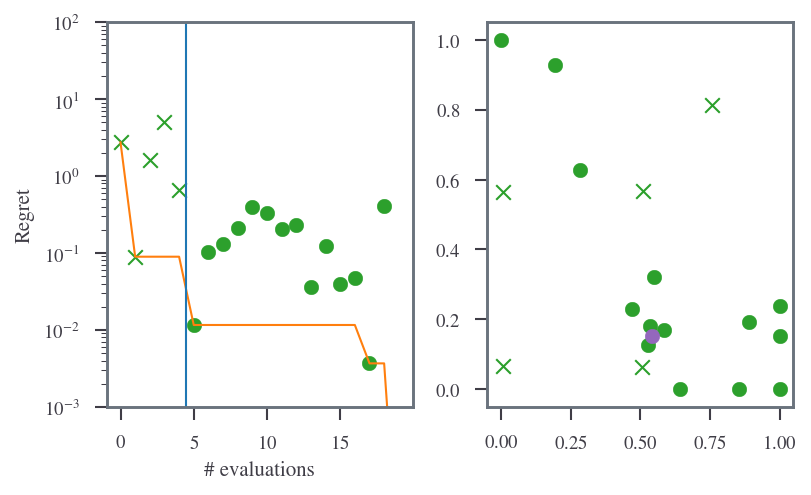

In [40]:
import matplotlib.pyplot as plt
from trieste.experimental.plotting import plot_regret

suboptimality = observations - ScaledBranin.minimum.numpy()
_, ax = plt.subplots(1, 2)
plot_regret(
    suboptimality, ax[0], num_init=num_initial_points, idx_best=arg_min_idx
)
plot_bo_points(
    query_points, ax[1], num_init=num_initial_points, idx_best=arg_min_idx
)

ax[0].set_yscale("log")
ax[0].set_ylabel("Regret")
ax[0].set_ylim(0.001, 100)
ax[0].set_xlabel("# evaluations")

╒═════════════════════════╤══════════════════╤══════════════════╤═══════════╤═════════════╤═══════════╤═════════╤═══════════════════════╕
│ name                    │ class            │ transform        │ prior     │ trainable   │ shape     │ dtype   │ value                 │
╞═════════════════════════╪══════════════════╪══════════════════╪═══════════╪═════════════╪═══════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter        │ Identity         │           │ True        │ ()        │ float64 │ 1.41751               │
├─────────────────────────┼──────────────────┼──────────────────┼───────────┼─────────────┼───────────┼─────────┼───────────────────────┤
│ GPR.kernel.variance     │ Parameter        │ Softplus         │ LogNormal │ True        │ ()        │ float64 │ 3.55163               │
├─────────────────────────┼──────────────────┼──────────────────┼───────────┼─────────────┼───────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscales │ Parame

Text(0.5, 0, '# Evaluations')

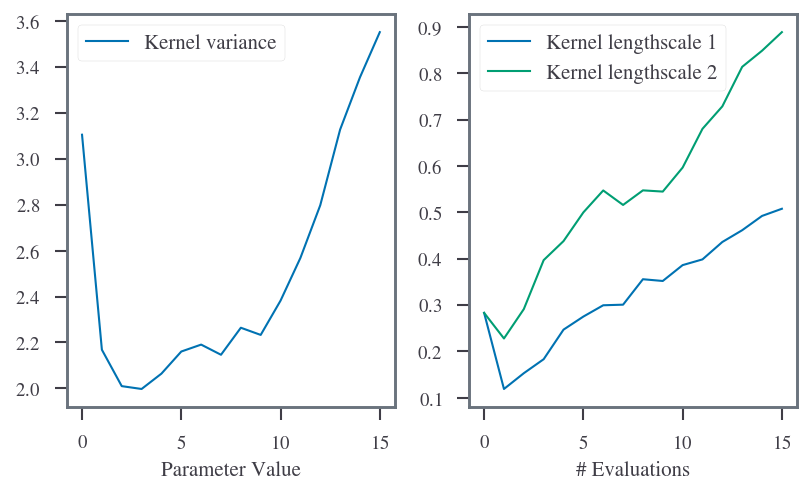

In [41]:
gpflow.utilities.print_summary(
    result.try_get_final_model().model  # type: ignore
)


## Trieste active learning example